In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## dataset

In [2]:
ratebeer = pd.read_json("./data/ratebeer_korea.json")

In [3]:
ratebeer.tail()

,reviewScore,reviewTime,reviewText,appearance,aroma,palate,taste,overall,profileName,beerName,beerID,brewerID,ABV,style,imageUrl
94316,3.0,2000-06-14 04:58:02.000,"pale clear golden colour with a fine head, low...",4.0,5.0,3.0,6.0,12.0,Bov,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94317,4.2,2000-06-10 16:51:58.000,"love that skunky smell ! Actually, my fav eve...",4.0,9.0,4.0,8.0,17.0,sallyclub99,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94318,2.7,2000-06-05 08:46:21.000,Much better than American pilsners which isn't...,2.0,5.0,2.0,6.0,12.0,kublai3,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94319,3.3,2000-06-03 23:59:02.000,"A decent, light-German beer. Not bad, but then...",3.0,6.0,3.0,6.0,15.0,Aubrey,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...
94320,3.3,2000-05-07 01:07:31.000,Beck's is a decent german beer. It's a little...,3.0,6.0,4.0,7.0,13.0,roland,Beck's,703,112,4.8,Pale Lager - International / Premium,https://res.cloudinary.com/ratebeer/image/uplo...


In [4]:
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93623 entries, 0 to 94320
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewScore  93620 non-null  float64
 1   reviewTime   93623 non-null  object 
 2   reviewText   93623 non-null  object 
 3   appearance   92036 non-null  float64
 4   aroma        92036 non-null  float64
 5   palate       92036 non-null  float64
 6   taste        92036 non-null  float64
 7   overall      92036 non-null  float64
 8   profileName  93623 non-null  object 
 9   beerName     93623 non-null  object 
 10  beerID       93623 non-null  int64  
 11  brewerID     93623 non-null  int64  
 12  ABV          93623 non-null  float64
 13  style        93623 non-null  object 
 14  imageUrl     93623 non-null  object 
dtypes: float64(7), int64(2), object(6)
memory usage: 11.4+ MB


In [5]:
ratebeer = ratebeer.dropna(subset=['reviewScore'])
ratebeer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93620 entries, 0 to 94320
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   reviewScore  93620 non-null  float64
 1   reviewTime   93620 non-null  object 
 2   reviewText   93620 non-null  object 
 3   appearance   92036 non-null  float64
 4   aroma        92036 non-null  float64
 5   palate       92036 non-null  float64
 6   taste        92036 non-null  float64
 7   overall      92036 non-null  float64
 8   profileName  93620 non-null  object 
 9   beerName     93620 non-null  object 
 10  beerID       93620 non-null  int64  
 11  brewerID     93620 non-null  int64  
 12  ABV          93620 non-null  float64
 13  style        93620 non-null  object 
 14  imageUrl     93620 non-null  object 
dtypes: float64(7), int64(2), object(6)
memory usage: 11.4+ MB


### 편의점 유통 맥주만 가져오기

In [6]:
# # 편의점 유통 맥주 리스트 csv
# kor_beer_list_csv = pd.read_csv("./data/ratebeer_list_inKorea.csv",header=None, names = ['name', 'id', 'review_count'])

# # 결측치 처리
# kor_beer_list_csv['review_count'].fillna(0, inplace = True)
# # id 타입 변환(기존 데이터와 통일)
# kor_beer_list_csv['id'] = kor_beer_list_csv['id'].astype(str)

In [7]:
# # 편의점 유통 맥주 list
# kor_beer_list = kor_beer_list_csv['id'].unique()
# len(kor_beer_list)

In [8]:
# # 전체 데이터에서 한국 편의점 맥주만 추출
# ratebeer_kor = ratebeer[ratebeer['beer/beerId'].isin(kor_beer_list)].reset_index(drop = True)
# ratebeer_kor

In [9]:
# 전체 데이터에서 한국 편의점 맥주 개수
len(ratebeer['beerName'].unique())

81

### preprocessing

In [10]:
def preprocessing_df(df):
    # rating 전처리
    # df['rating/apperance'] = df['review/appearance'].str.split("/").str[0].astype(int)
    # df['rating/aroma'] = df['review/aroma'].str.split("/").str[0].astype(int)
    # df['rating/palate'] = df['review/palate'].str.split("/").str[0].astype(int)
    # df['rating/taste'] = df['review/taste'].str.split("/").str[0].astype(int)
    # df['rating/overall'] = df['review/overall'].str.split("/").str[0].astype(int)
    
    # overall rating 최대치 5로 변환
    # df['rating/overall'] = df['rating/overall'] / 20 * 5
    
    # item, user, rating만 추출
    df = df[['beerID', 'profileName', 'reviewScore']]
    df.rename(columns={'beerID' : 'item_id', 'profileName' : 'user', 'reviewScore' : 'rating'}, inplace = True) 
    
    # 유저 리뷰 수 개산
    df['user/reviewcount'] = df.groupby('user')['user'].transform('count')
    # 리뷰 수가 10개 이상인 유저만 남김 
    df = df[(df['user/reviewcount'] > 10)]
    
    df.drop(columns=['user/reviewcount'], inplace=True)
    
    num_users = df.user.unique().shape[0]
    num_items = df.item_id.unique().shape[0]
    return df, num_users, num_items

### Statistics of the Dataset

In [11]:
data, num_users, num_items = preprocessing_df(ratebeer)
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head())

number of users: 2737, number of items: 80
matrix sparsity: 0.740930
   item_id        user  rating
0    75661  Grzesiek79     1.3
1    75661    GriZZZly     2.7
2    75661   bdleedahl     3.3
3    75661    DoctorHU     2.6
4    75661     McTapps     2.5


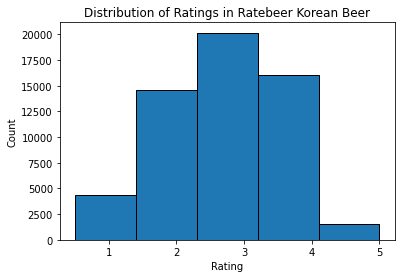

In [12]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in Ratebeer Korean Beer')
plt.show()

### Label Encoding

In [13]:
user_le = LabelEncoder()
item_le = LabelEncoder()
data['user_id_idx'] = user_le.fit_transform(data['user'].values)
data['item_id_idx'] = item_le.fit_transform(data['item_id'].values)

data.drop(columns=['user', 'item_id'], inplace=True)

### Loading the data

In [14]:
class BeerDataset(Dataset):
    def __init__(self, df, mode='train'):
        self.df = df
        self.mode = mode
        self.train_size = 0.8
        self.val_size = 0.1
        self.test_size = 1 - self.train_size - self.val_size 

        self.num_items = len(self.df['item_id_idx'].unique())
        self.num_users = len(self.df['user_id_idx'].unique())
        
        n_val = int(self.num_users * self.val_size)
        n_test = int(self.num_users * self.test_size)
        
        random.seed(42)
        
        val_indices = set(random.choices(range(self.num_users), k=n_val))
        test_indices = set(random.choices(list(set(range(self.num_users)) - val_indices), k=n_test))
        train_indices = set(range(self.num_users)) - val_indices - test_indices
    
        # self.train_df, self.test_df = train_test_split(self.df, test_size=self.test_size, train_size=self.train_size, stratify = self.df['user_id_idx'].values, random_state=42)
                        
        if self.mode == 'train':
            self.df = self.df[self.df['user_id_idx'].isin(train_indices)]
        elif self.mode == 'val':
            self.df = self.df[self.df['user_id_idx'].isin(val_indices)]
        else:
            self.df = self.df[self.df['user_id_idx'].isin(test_indices)]

        self.users = torch.tensor(self.df['user_id_idx'].values)
        self.items = torch.tensor(self.df['item_id_idx'].values)
        self.ratings = torch.tensor(self.df['rating'].values)
        
        self.inter_mat = self.make_inter_mat()
    
    def make_inter_mat(self):
        inter_mat = np.zeros((self.num_users, self.num_items))
        for user, item, rating in zip(self.users, self.items, self.ratings):
            inter_mat[user][item] = rating

        return inter_mat

    def __len__(self):
        return len(self.inter_mat)

    def __getitem__(self, index):
        inter_mat = torch.tensor(self.inter_mat[index]).float()

        return index, inter_mat

### Autorec Model

In [15]:
class AutoRec(nn.Module):
    def __init__(self, num_hidden, num_items, dropout=0.05):
        super(AutoRec, self).__init__()
        self.encoder = nn.Linear(num_items, num_hidden)
        self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Linear(num_hidden, num_items)
        self.dropout = nn.Dropout(dropout)

    def forward(self, mat):
        hidden = self.dropout(self.sigmoid(self.encoder(mat)))
        pred = self.decoder(hidden)
        
        return pred

###  Model train, validcation

In [16]:
def train(model, train_iter, criterion, optm, device):
    model.train() # to train mode
    loss_sum = 0

    for _, inter_mat in train_iter:
        inter_mat = inter_mat.to(device)    

        preds = model(inter_mat)
        loss = criterion(preds, inter_mat)

        # Update
        optm.zero_grad()      # reset gradient 
        loss.backward()      # backpropagate
        optm.step()      # optimizer update
        
        loss_sum += loss.item()
        
    loss_avg = loss_sum / len(train_iter)

    return loss_avg

In [17]:
def validation(model, valid_iter, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum = 0

        for _, inter_mat in valid_iter:
            inter_mat = inter_mat.to(device) 

            preds = model(inter_mat)
            loss = criterion(preds, inter_mat)            

            loss_sum += loss.item()

    loss_avg = loss_sum / len(valid_iter)

    return loss_avg

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 64

num_items = data.item_id_idx.nunique()
num_hidden = 100

In [19]:
train_dataset = BeerDataset(df=data, mode='train')
val_dataset = BeerDataset(df=data, mode='val')

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) 
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [20]:
model = AutoRec(num_hidden, num_items).to(device)
loss = nn.MSELoss()
optm = optim.Adam(model.parameters(),lr=lr)

epoch: 0, train Loss: 1.0485, test Loss: 0.4713
epoch: 1, train Loss: 0.7679, test Loss: 0.3325
epoch: 2, train Loss: 0.7129, test Loss: 0.2778
epoch: 3, train Loss: 0.6593, test Loss: 0.2282
epoch: 4, train Loss: 0.6104, test Loss: 0.1826
epoch: 5, train Loss: 0.5650, test Loss: 0.1501
epoch: 6, train Loss: 0.5252, test Loss: 0.1212
epoch: 7, train Loss: 0.4878, test Loss: 0.0995
epoch: 8, train Loss: 0.4529, test Loss: 0.0856
epoch: 9, train Loss: 0.4227, test Loss: 0.0738
epoch: 10, train Loss: 0.3931, test Loss: 0.0636
epoch: 11, train Loss: 0.3667, test Loss: 0.0565
epoch: 12, train Loss: 0.3433, test Loss: 0.0508
epoch: 13, train Loss: 0.3197, test Loss: 0.0447
epoch: 14, train Loss: 0.3004, test Loss: 0.0411
epoch: 15, train Loss: 0.2796, test Loss: 0.0370
epoch: 16, train Loss: 0.2629, test Loss: 0.0337
epoch: 17, train Loss: 0.2466, test Loss: 0.0306
epoch: 18, train Loss: 0.2316, test Loss: 0.0284
epoch: 19, train Loss: 0.2177, test Loss: 0.0260
epoch: 20, train Loss: 0.2059,

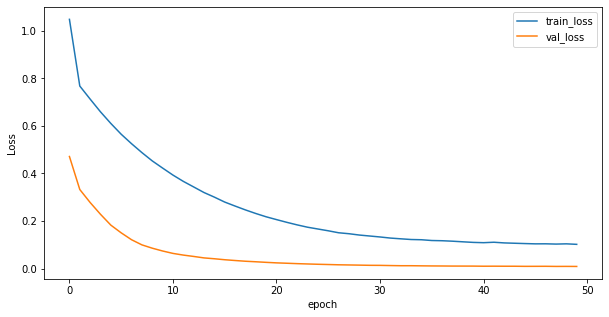

In [21]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    train_loss = train(model, train_dataloader, loss, optm, device)
    val_loss = validation(model, val_dataloader, loss, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'epoch: {epoch}, train Loss: {train_loss:.4f}, test Loss: {val_loss:.4f}')

plt.figure(figsize=(10,5))
plt.plot(train_losses,label="train_loss")
plt.plot(val_losses,label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
PATH = './model/autorec_crawling.pt'
torch.save(model.state_dict(), PATH)

### inference

In [23]:
model = AutoRec(num_hidden, num_items).to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
def ndcg_k(actual, predicted, topk):
    res = 0
    for user_id in range(len(actual)):
        k = min(topk, len(actual[user_id]))
        idcg = idcg_k(k)
        dcg_k = sum(
            [
                int(predicted[user_id][j] in set(actual[user_id])) / math.log(j + 2, 2)
                for j in range(topk)
            ]
        )
        res += dcg_k / idcg
    return res / float(len(actual))

# Calculates the ideal discounted cumulative gain at k
def idcg_k(k):
    res = sum([1.0 / math.log(i + 2, 2) for i in range(k)])
    if not res:
        return 1.0
    else:
        return res

def recall_at_k(actual, predicted, topk):
    sum_recall = 0.0
    num_users = len(predicted)
    true_users = 0
    for i in range(num_users):
        act_set = set(actual[i])
        pred_set = set(predicted[i][:topk])
        if len(act_set) != 0:
            sum_recall += len(act_set & pred_set) / float(len(act_set))
            true_users += 1
    return sum_recall / true_users

In [25]:
def inference(model, test_iter, test_matrix, device, topk = 4):
    pred_list = None
    answer_list = None
    with torch.no_grad():
        model.eval()

        for i, (user_ids, inter_mat) in enumerate(test_iter):
            inter_mat = inter_mat.to(device)
            
            rating_pred = model(inter_mat)
            
            rating_pred = rating_pred.cpu().data.numpy().copy()
            
            batch_user_index = user_ids.cpu().numpy()
            answers = test_matrix.argsort(axis = 1)[batch_user_index, -topk:]
            # rating_pred[test_matrix[batch_user_index] > 0] = 0
            
            ind = np.argpartition(rating_pred, -topk)[:, -topk:]
            
            arr_ind = rating_pred[np.arange(len(rating_pred))[:, None], ind]

            arr_ind_argsort = np.argsort(arr_ind)[np.arange(len(rating_pred)), ::-1]

            batch_pred_list = ind[
                np.arange(len(rating_pred))[:, None], arr_ind_argsort
            ]

            if i == 0:
                pred_list = batch_pred_list
                answer_list = answers
            else:
                pred_list = np.append(pred_list, batch_pred_list, axis=0)
                answer_list = np.append(
                        answer_list, answers, axis=0
                )
            
        recall = recall_at_k(answer_list, pred_list, topk)
        ndcg = ndcg_k(answer_list, pred_list, topk)
        
        print(f'recall@{topk} = {recall}, ndcg@{topk} = {ndcg}')
    return pred_list, answer_list

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_epochs = 50
lr = 0.001
batch_size = 64

num_items = data.item_id_idx.nunique()
num_hidden = 100

In [27]:
test_dataset = BeerDataset(df=data, mode='test')

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

test_matrix = test_dataset.inter_mat

In [28]:
pred_list, answer_list = inference(model, test_dataloader, test_matrix, device, topk=4)

recall@4 = 0.07617829740591889, ndcg@4 = 0.07972663016631774


In [29]:
test_dataset.df.user_id_idx.unique()

array([2379,   78,  870, 1140,   15, 2603, 2466, 1747, 1680,   26, 1043,
       1654,   73,  403,   51,   69,  756,    5,  174,  856, 1902, 2540,
       2471,  414,  299,  699, 2417,  903,  530,  763,   65, 1149, 2635,
        734, 2414, 1835, 1136,  190, 1846,   74, 1863,  542,  225, 2233,
       2451, 2594, 1194,  576, 1784,  526, 2080, 1047,  350, 1588,  866,
       2151, 1215, 2092,  347, 2342, 2312,  852, 1299, 2538,  420, 2056,
        294, 2104,  298, 2317, 1181,  965,  692, 2134,  316,    2, 2172,
       1942,  716, 1151, 1303,  727, 1788, 2054,  605,  459, 1152,  754,
       2016, 2409,  774, 1663,  929, 1906,  318,  201,  541, 2045,  738,
        832, 1936, 2268, 1908, 1994, 1970, 2337,  207, 1340,  676, 1917,
        619,  640, 1119, 1745,  768,  255, 2359,  917, 1499, 2699,  795,
        833,   14, 2097, 1657, 2028, 1121, 1116,  379,  818,  678,  372,
       1283, 1800, 1268, 1859, 2107, 1478,  212, 2435,  791, 2174, 1687,
       1197, 2235,  563, 2649, 2525, 2565, 1400, 20

In [30]:
pred_list[2379]

array([ 6, 23, 18, 58])

In [31]:
answer_list[2379]

array([58, 18,  6, 23])

In [32]:
test_matrix[2379]

array([2.3, 0. , 0. , 3. , 2.5, 0. , 4.3, 1.1, 2. , 3.4, 1.8, 2.4, 1.5,
       2.4, 0. , 2.7, 2.5, 1.7, 3.6, 3. , 2.8, 2.8, 0. , 4.3, 3.2, 3.1,
       2.8, 3.3, 0. , 2.8, 0. , 2.2, 0. , 0. , 1.9, 2.1, 0. , 0. , 0. ,
       2. , 0. , 0. , 0. , 0. , 3. , 2.3, 0. , 0. , 0. , 0. , 2. , 3. ,
       0. , 0. , 0. , 0. , 2.9, 0. , 3.5, 2.7, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. ])